## #01. 준비작업
### [1] 패키지 가져오기

In [58]:
from helper.util import *
from helper.plot import *
from helper.tensor import *
from helper.re import *

from datetime import datetime as dt
from kerastuner import Hyperband

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from ipywidgets import interact

from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.random import set_seed
from tensorflow.keras.initializers import GlorotUniform

set_seed(get_random_state())
__initializer__ = GlorotUniform(seed=get_random_state())

## 01. 보스턴 집값 예측모형을 신경망 기반으로 구현하시오

1. 범주형을 제외한 변수는 MinMax 스케일링을 수행
2. 학습 수행 전 다중공선성을 제거
3. 위 조건에 대하여 다중선형회귀, 다항선형회귀모형으로 구현

### [1] 데이터 가져오기

In [59]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx", info=False)

### [2] 스케일링


In [60]:
df = my_minmax_scaler(origin, 'MEDV')
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680,24.0
1,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470,21.6
2,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466,34.7
3,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389,33.4
4,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.000633,0.00,0.420455,0.0,0.386831,0.580954,0.681771,0.122671,0.000000,0.164122,0.893617,0.987619,0.219095,22.4
502,0.000438,0.00,0.420455,0.0,0.386831,0.490324,0.760041,0.105293,0.000000,0.164122,0.893617,1.000000,0.202815,20.6
503,0.000612,0.00,0.420455,0.0,0.386831,0.654340,0.907312,0.094381,0.000000,0.164122,0.893617,1.000000,0.107892,23.9
504,0.001161,0.00,0.420455,0.0,0.386831,0.619467,0.889804,0.114514,0.000000,0.164122,0.893617,0.991301,0.131071,22.0


### [3] 학습 수행 전 다중공선성을 제거

In [61]:
df2 = my_vif_filter(origin, 'MEDV')
df2

,CRIM,ZN,INDUS,DIS,RAD,B,LSTAT,CHAS,MEDV
0,0.00632,18.0,2.31,4.0900,1,396.90,4.98,0,24.0
1,0.02731,0.0,7.07,4.9671,2,396.90,9.14,0,21.6
2,0.02729,0.0,7.07,4.9671,2,392.83,4.03,0,34.7
3,0.03237,0.0,2.18,6.0622,3,394.63,2.94,0,33.4
4,0.06905,0.0,2.18,6.0622,3,396.90,5.33,0,36.2
...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,2.4786,1,391.99,9.67,0,22.4
502,0.04527,0.0,11.93,2.2875,1,396.90,9.08,0,20.6
503,0.06076,0.0,11.93,2.1675,1,396.90,5.64,0,23.9
504,0.10959,0.0,11.93,2.3889,1,393.45,6.48,0,22.0


### [4] 모델구현하기
#### (1) 다중선형회귀 

##### 1) 데이터 분할

In [62]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, yname='MEDV')
rows, cols = x_train.shape
rows, cols

(404, 8)

##### 2) 신경망 정의

| 구분 | 모델 | 활성화 함수 | 옵티마이저 | 손실함수 | 평가지표 | 대표예제 |
|--|--|--|--|--|--|--|
| 회귀 | 단순선형회귀 | relu, relu, linear | adam | mse | mae | 보스턴 집값 예측 |

##### 3) 하이퍼 파라미터 튜닝

###### 모델 생성 함수 정의

In [63]:
def tf_build(hp) -> Sequential:
    # print(type(hp))
    model = Sequential()

    model.add(
        Dense(
            units=hp.Choice("units", values=[32, 64, 128,256,512]),
            activation="relu",
            input_shape=(cols,),
        )
    )
    model.add(
        Dense(
            units=hp.Choice("units", values=[16, 32, 64,128,256]),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss="mse",
        metrics=["mae"],
    )

    return model

###### 튜닝수행

In [64]:
tuner = Hyperband(
    hypermodel=tf_build, # 하이퍼파라미터를 튜닝하기 위한 모델 생성 함수
    objective="val_mae", # 최적화 기준값
    max_epochs=10,     
    factor=3,
    seed=get_random_state(),
    directory="D:\\tensor_hyperband",
    project_name="tf_hyperband_%s" % dt.now().strftime("%Y%m%d%H%M%S"),
)

tuner

In [65]:
tuner.search(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test)
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()

if not best_hps:
    raise ValueError("No best hyperparameters found.")

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps[0].get('units')} and the optimal learning rate for the optimizer
is {best_hps[0].get('learning_rate')}.
"""
)

Trial 21 Complete [00h 00m 02s]
val_mae: 45.02643966674805

Best val_mae So Far: 4.939619541168213
Total elapsed time: 00h 00m 46s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256 and the optimal learning rate for the optimizer
is 0.01.



###### 학습 결과 평가

+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 18.9827 | 3.27359 |
| test  |  32.595 | 3.70952 |
+-------+---------+---------+


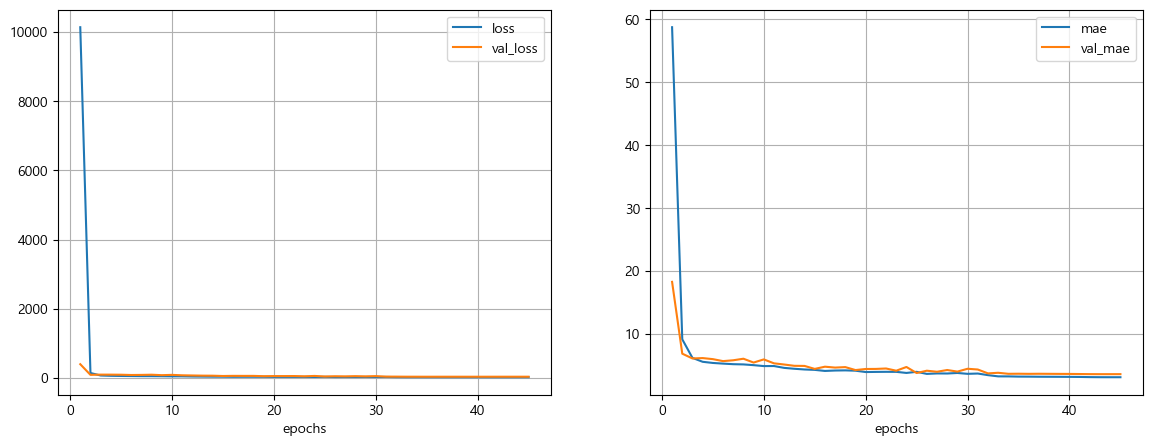

In [66]:
model = tuner.hypermodel.build(best_hps[0])
result = tf_train(model, x_train, y_train, x_test, y_test)
tf_result(result)

#### (2) 다항선형회귀모형

##### 1) 다항식으로 변환

In [67]:
df3 = my_poly_features(data=df, ignore=['MEDV'])
my_pretty_table(data=df2.head())

+----+---------+------+---------+--------+-------+--------+---------+--------+--------+
|    |    CRIM |   ZN |   INDUS |    DIS |   RAD |      B |   LSTAT |   CHAS |   MEDV |
|----+---------+------+---------+--------+-------+--------+---------+--------+--------|
|  0 | 0.00632 |   18 |    2.31 |   4.09 |     1 |  396.9 |    4.98 |      0 |     24 |
|  1 | 0.02731 |    0 |    7.07 | 4.9671 |     2 |  396.9 |    9.14 |      0 |   21.6 |
|  2 | 0.02729 |    0 |    7.07 | 4.9671 |     2 | 392.83 |    4.03 |      0 |   34.7 |
|  3 | 0.03237 |    0 |    2.18 | 6.0622 |     3 | 394.63 |    2.94 |      0 |   33.4 |
|  4 | 0.06905 |    0 |    2.18 | 6.0622 |     3 |  396.9 |    5.33 |      0 |   36.2 |
+----+---------+------+---------+--------+-------+--------+---------+--------+--------+


##### 2) 다중공선성 제거

In [68]:
df4 = my_vif_filter(df3, 'MEDV')
my_pretty_table(df4.head())

+----+-------------+-----------+-------------+-------------+-------------+--------+------------+-----------+-----------+----------+-----------+--------------+------------+------------+-------------+------------+-----------+------------+--------------+-----------+-----------+----------+----------+-----------+-----------+------------+--------+----------+--------+
|    |      CRIM^2 |   CRIM ZN |   CRIM CHAS |    CRIM DIS |      CRIM B |   ZN^2 |   ZN INDUS |   ZN CHAS |    ZN NOX |   ZN RAD |    ZN TAX |   ZN PTRATIO |   ZN LSTAT |    INDUS^2 |   INDUS DIS |   CHAS NOX |   CHAS RM |   CHAS RAD |   CHAS LSTAT |     NOX^2 |   NOX DIS |     RM^2 |    AGE^2 |     DIS^2 |     RAD B |    LSTAT^2 |   CHAS |   CHAS^2 |   MEDV |
|----+-------------+-----------+-------------+-------------+-------------+--------+------------+-----------+-----------+----------+-----------+--------------+------------+------------+-------------+------------+-----------+------------+--------------+-----------+---------

##### 3) 데이터 분할

In [69]:
x_train, x_test, y_train, y_test = my_train_test_split(df4, yname='MEDV')
rows, cols = x_train.shape
rows, cols

(404, 28)

##### 4) 신경망 정의

| 구분 | 모델 | 활성화 함수 | 옵티마이저 | 손실함수 | 평가지표 | 대표예제 |
|--|--|--|--|--|--|--|
| 회귀 | 단순선형회귀 | relu, relu, linear | adam | mse | mae | 보스턴 집값 예측 |

##### 5) 하이퍼 파라미터 튜닝

###### 튜닝 수행

In [70]:
tuner = Hyperband(
    hypermodel=tf_build, # 하이퍼파라미터를 튜닝하기 위한 모델 생성 함수
    objective="val_mae", # 최적화 기준값
    max_epochs=10,     
    factor=3,
    seed=get_random_state(),
    directory="D:\\tensor_hyperband",
    project_name="tf_hyperband_%s" % dt.now().strftime("%Y%m%d%H%M%S"),
)

tuner

In [71]:
tuner.search(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test)
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()

if not best_hps:
    raise ValueError("No best hyperparameters found.")

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps[0].get('units')} and the optimal learning rate for the optimizer
is {best_hps[0].get('learning_rate')}.
"""
)

Trial 21 Complete [00h 00m 02s]
val_mae: 21.836502075195312

Best val_mae So Far: 3.374856472015381
Total elapsed time: 00h 00m 48s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.01.



###### 학습 결과 평가

+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 6.59591 | 1.92984 |
| test  | 14.3773 | 2.74935 |
+-------+---------+---------+


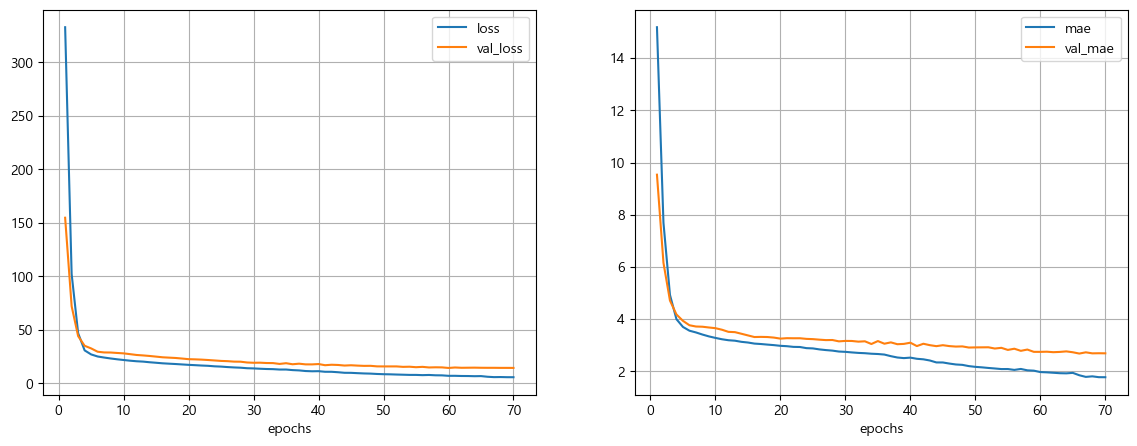

In [72]:
model = tuner.hypermodel.build(best_hps[0])
result = tf_train(model, x_train, y_train, x_test, y_test)
tf_result(result)

## #02. 타이타닉
### [1] 데이터 가져오기

In [73]:
origin = my_read_excel("https://data.hossam.kr/edadata/titanic.xlsx", index_col='PassengerId', categories=['Survived', 'Pclass', 'Sex', 'Embarked'], info=False)

### [2] 전처리

이전 수업내용과 동일

In [74]:
df = origin.copy()

# 1. 생존 여부에 따른 평균 나이로 결측치 치환
mean_age_df = df[['Survived','Age']].groupby('Survived').mean()

for i in mean_age_df.index:
    mean_age = round(mean_age_df.loc[i]['Age'], 0)
    expr = (df['Survived'] == i) & (df['Age'].isna())
    df.loc[expr, 'Age'] = df.loc[expr, 'Age'].fillna(mean_age)

# 2. 히스토그램 구간에 따라 나이를 명목형으로 변환
hist, bins = np.histogram(df['Age'], bins=5)

df2 = df.copy()
df2.loc[ df2['Age'] <= 16, "Age"] = 0
df2.loc[ (df2['Age'] > 16) & (df2['Age'] <= 32), "Age"] = 1
df2.loc[ (df2['Age'] > 32) & (df2['Age'] <= 48), "Age"] = 2
df2.loc[ (df2['Age'] > 48) & (df2['Age'] <= 64), "Age"] = 3
df2.loc[ df2['Age'] > 64, "Age"] = 4

# 3. 객실 유무에 따른 명목형 변수 생성
df2['Has_Cabin'] = df2['Cabin'].apply(lambda x:  0 if type(x) == float else 1)
df2['Has_Cabin'].value_counts()

# 4. 가족 구성원 수 파생변수 생성
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1

# 5. 혼자 탑승했는지에 대한 파생변수 생성
df2['IsAlone'] = 0
df2.loc[df2['FamilySize'] == 1, 'IsAlone'] = 1

# 6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
most_embarked_df = df2[['Survived','Embarked']].groupby('Survived').agg(Series.mode)

for i in most_embarked_df.index:
    most = most_embarked_df.loc[i]['Embarked']
    expr = (df2['Survived'] == i) & (df2['Embarked'].isna())
    df2.loc[expr, 'Embarked'] = df2.loc[expr, 'Embarked'].fillna(most)

# 7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
mean_fare_df = df2[['Survived','Fare']].groupby('Survived').mean()

for i in mean_fare_df.index:
    mean_fare = mean_fare_df.loc[i]['Fare']
    expr = (df2['Survived'] == i) & (df2['Fare'].isna())
    df2.loc[expr, 'Fare'] = df2.loc[expr, 'Fare'].fillna(mean_fare)

# 8. 이름으로부터 호칭 파생변수 생성
df2['Title'] = df2['Name'].apply(get_title)

df2['Title'] = df2['Title'].replace(['Rev', 'Dr', 
                'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 
                'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer', 'Dona'], "Rare")

# 9. 데이터 라벨링
df3 = my_labelling(df2, 'Title', 'Embarked', 'Sex')

# 10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
df3.loc[ df3['Fare'] <= 7.9, "Fare"] = 0
df3.loc[ (df2['Fare'] > 7.9) & (df3['Fare'] <= 14.5), "Fare"] = 1
df3.loc[ (df3['Fare'] > 14.5) & (df3['Fare'] <= 31.3), "Fare"] = 2
df3.loc[ df3['Fare'] > 31.3, "Fare"] = 3

# 11. 불필요한 컬럼 제거
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
df4 = df3.drop(drop_elements, axis = 1)

my_pretty_table(df4.head())

+---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------+
|   PassengerId |   Survived |   Pclass |   Sex |   Age |   Fare |   Embarked |   Has_Cabin |   FamilySize |   IsAlone |   Title |
|---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------|
|             1 |          0 |        3 |     1 |     1 |      0 |          2 |           0 |            2 |         0 |       2 |
|             2 |          1 |        1 |     0 |     2 |      3 |          0 |           1 |            2 |         0 |       3 |
|             3 |          1 |        3 |     0 |     1 |      1 |          2 |           0 |            1 |         1 |       1 |
|             4 |          1 |        1 |     0 |     2 |      3 |          2 |           1 |            2 |         0 |       3 |
|             5 |          0 |        3 |     1 |     2 |      1 |          2 |    

### [3] 모델 구현하기
#### (1) 데이터 분할

In [75]:
df4['Pclass'] = df4['Pclass'].astype('int')
df4['Survived'] = df4['Survived'].astype('int')
x_train, x_test, y_train, y_test = my_train_test_split(df4, yname='Survived')
rows, cols = x_train.shape
rows, cols


(1047, 9)

#### (2) 신경망 정의

| 구분 | 모델 | 활성화 함수 | 옵티마이저 | 손실함수 | 평가지표 | 대표예제 |
|--|--|--|--|--|--|--|
| 분류 | 이항분류 | [relu,] sigmoid | rmsporp | binary_crossentropy | acc | 타이타닉 생존률 예측 |
| 회귀 | 단순선형회귀 | relu, relu, linear | adam | mse | mae | 보스턴 집값 예측 |

In [76]:
def tf_build(hp) -> Sequential:
    # print(type(hp))
    model = Sequential()

    model.add(
        Dense(
            units=hp.Choice("units", values=[32, 64, 128,256,512]),
            activation="relu",
            input_shape=(cols,),
        )
    )
    model.add(
        Dense(
            units=hp.Choice("units", values=[16, 32, 64,128,256]),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=RMSprop(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss="binary_crossentropy",
        metrics=["acc"],
    )

    return model

#### (3) 하이퍼 파라미터 튜닝

In [77]:
tuner = Hyperband(
    hypermodel=tf_build, # 하이퍼파라미터를 튜닝하기 위한 모델 생성 함수
    objective="val_acc", # 최적화 기준값
    max_epochs=10,     
    factor=3,
    seed=get_random_state(),
    directory="D:\\tensor_hyperband",
    project_name="tf_hyperband_%s" % dt.now().strftime("%Y%m%d%H%M%S"),
)

tuner

##### 튜닝 수행

In [78]:
tuner.search(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test)
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()

if not best_hps:
    raise ValueError("No best hyperparameters found.")

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps[0].get('units')} and the optimal learning rate for the optimizer
is {best_hps[0].get('learning_rate')}.
"""
)

Trial 21 Complete [00h 00m 02s]
val_acc: 0.6183205842971802

Best val_acc So Far: 0.8778625726699829
Total elapsed time: 00h 00m 46s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 32 and the optimal learning rate for the optimizer
is 0.001.



##### 학습결과 평가

+-------+----------+----------+
|       |      acc |     loss |
|-------+----------+----------|
| train | 0.868195 | 0.340782 |
| test  | 0.885496 | 0.309525 |
+-------+----------+----------+


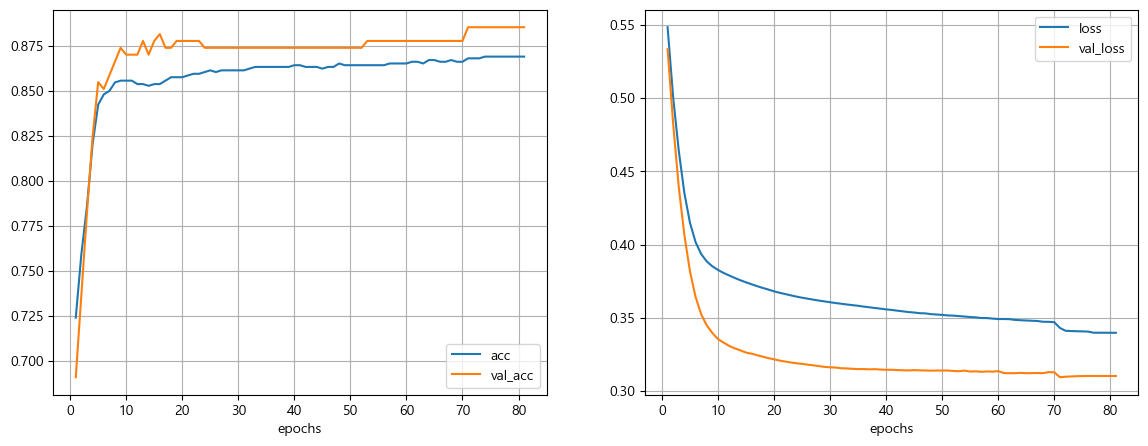

In [79]:
model = tuner.hypermodel.build(best_hps[0])
result = tf_train(model, x_train, y_train, x_test, y_test)
tf_result(result)